# Customer Segmentation

## Background

This dataset contains all purchases made for an online retail company based in the UK during an eight month period. We could use cluster analysis combined with RFM analysis to do a customer segmentation.

## Prepare and Explore the Data

For this experiment, we will use [this](https://www.kaggle.com/vijayuv/onlineretail) data from Kaggle platform.

In [ ]:
# Package imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', None)

In [ ]:
# Load data
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Since we want to segment our customers, we have to make sure that `CustomerID` is not null.

In [ ]:
df.shape

(541909, 8)

In [ ]:
# Check missing value
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


We could see that there is missing value in `CustomerID` columns. We could remove those missing values.

In [ ]:
# Remove missing value
df = df[df["CustomerID"].notna()]

df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


Then we could do some descriptive statistic.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [ ]:
# Simple descriptive statistic
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


Wait, hold on. How come the quantity is a negative number and the unit price is zero? Let's check it.

In [ ]:
# Check anomaly data (Ada berapa data yg kurang dari 0 untuk quantity dan sama dengan 0 untuk price)
quantity_zero = len(df[df["Quantity"] <= 0])
perc_quantity_zero = (len(df[df["Quantity"] <= 0]) / len(df)) * 100
unitprice_zero = len(df[df["UnitPrice"] == 0])
perc_unitprice_zero = (len(df[df["UnitPrice"] == 0]) / len(df)) * 100

print("The data consist of", str(quantity_zero), "rows of data with item quantity less/equal than zero.")
print("About {:.2f}% of total data".format(perc_quantity_zero))
print("")
print("The data consist of", str(unitprice_zero), "rows of data with unit price equal to zero.")
print("About {:.2f}% of total data".format(perc_unitprice_zero))

The data consist of 8905 rows of data with item quantity less/equal than zero.
About 2.19% of total data

The data consist of 40 rows of data with unit price equal to zero.
About 0.01% of total data


Then just remove those anomaly data

In [ ]:
# Remove anomaly / outliers
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


In [ ]:
df[(df["Quantity"] == 80995)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom


Now we're good to go. Lets do some data exploration!

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


In [ ]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

The data contains 406829 rows and 8 columns, each row represents each item in a purchasement. The columns are:
* `InvoiceNo` - Invoice number, to identify each invoice
* `StockCode` - Stock code, to identify each item in the inventory
* `Description` - Item's description
* `Quantity` - Number of purchased item in each invoice
* `InvoiceDate` - Date of purchasement
* `UnitPrice` - Item's price per unit
* `CustomerID` - Customer's identification number
* `Country` - Customer's country of origin

In [ ]:
# Check unique value
df[['InvoiceNo', 'StockCode', 'CustomerID', 'Country']].nunique()

,0
InvoiceNo,18532
StockCode,3665
CustomerID,4338
Country,37


There are 18532 purchasements, 3665 unique item purchased, from 4338 customers that came from 37 countries.

As we seen above, there are 37 countries of customer's origin. Since the retail company is based in the UK, we could simplified the country as UK or Non UK

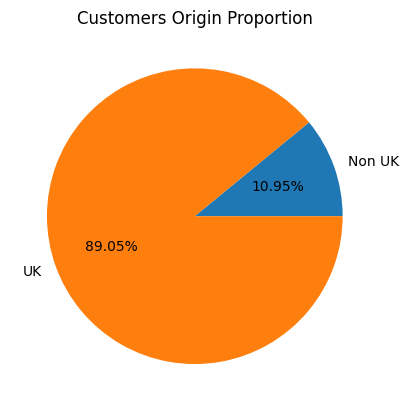

In [ ]:
# Simplify country origin (Pie chart untuk melihat komposisi negara)
df['Country_isUK'] = np.where(df['Country']=='United Kingdom', 'UK', 'Non UK')

customers_origin = df.groupby(['Country_isUK']).size()

plt.title('Customers Origin Proportion')
plt.pie(customers_origin, labels=customers_origin.index, autopct=lambda p: f'{p:.2f}%')
plt.show();

Based on the piechart, we could see that mostly our customers are from the UK.

Next, we could analyze the trend of purchasement. First, lets create `TotalAmount` column (`Quantity` * `UnitPrice`). Then, we could transform the `InvoiceDate` data type from string to date.

In [ ]:
# Create new features and cast date column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34


Then plot the trendline.

In [ ]:
import matplotlib.dates as mdates

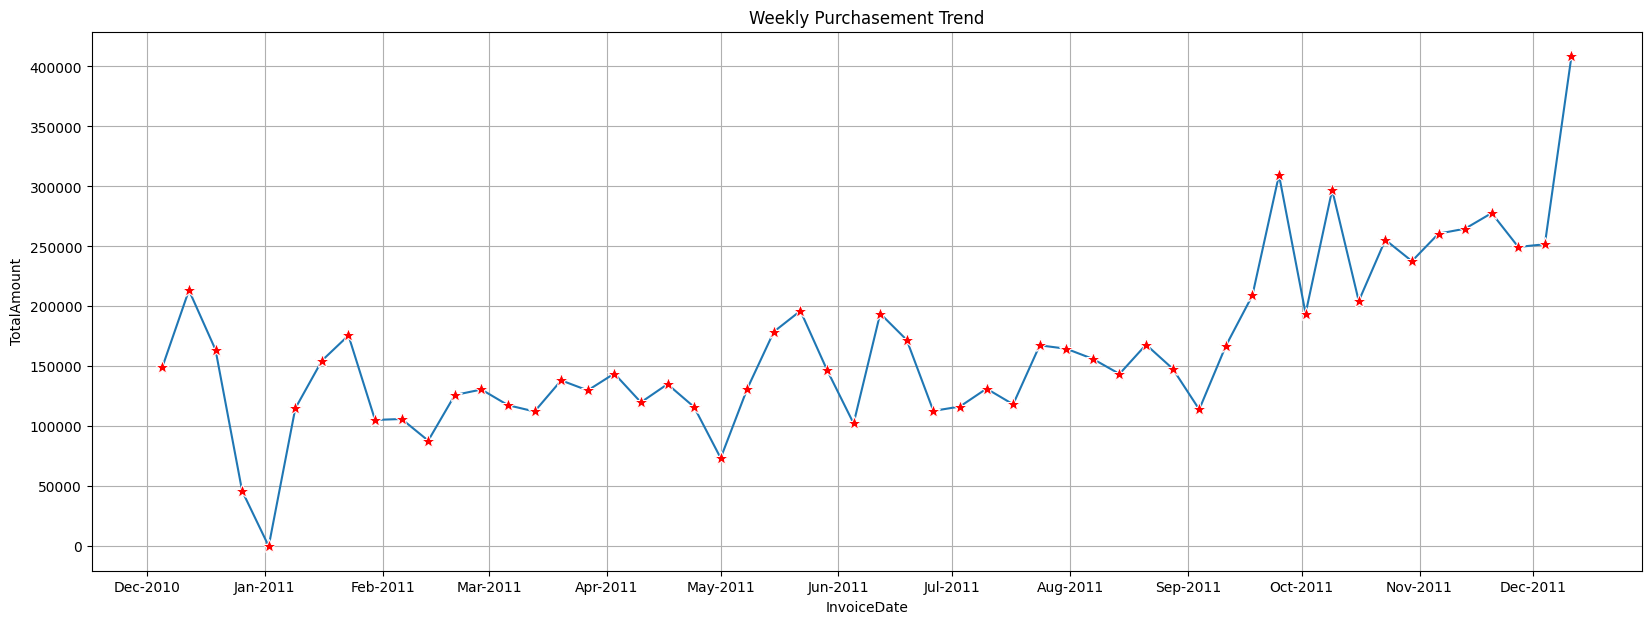

In [ ]:
# Plot weekly trend
weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(by=pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Weekly Purchasement Trend')
ax = sns.lineplot(
    x=weekly_purchasements.index,
    y=weekly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

<ipython-input-18-5b277a02505f>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()


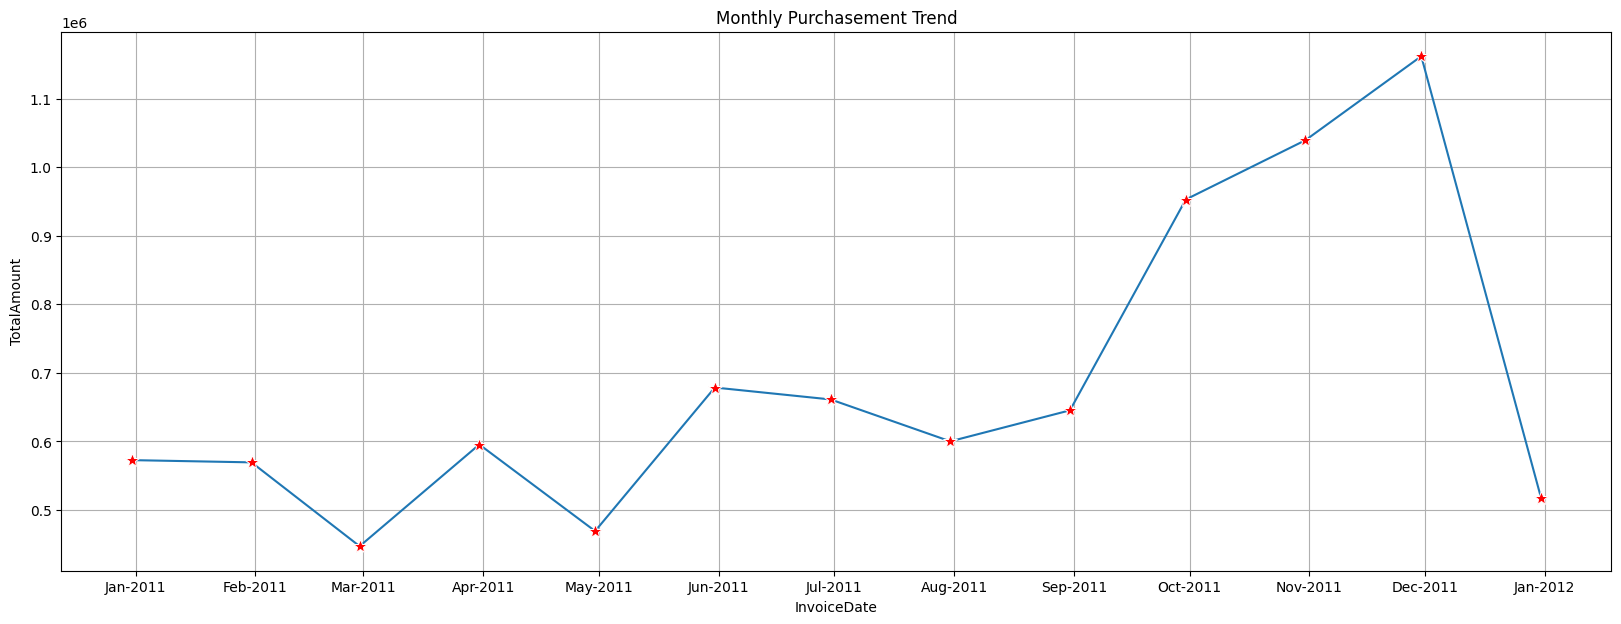

In [ ]:
# Plot monthly trend
monthly_purchasements = df.copy()
monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Monthly Purchasement Trend')
ax = sns.lineplot(
    x=monthly_purchasements.index,
    y=monthly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

Based on the picture above, it can be seen that there was an increase in total purchases at the end of the year.

## RFM

In this project, we would segment the customers using customer's demography and purchasement behavior. To explain the customer's demography, we could use `Country` column while to explain the customer's purchasement behavior we have to transform our data first to get those information. We could use RFM analysis to get those information.

### Recency

To measure customer's recency, we could substract the latest transaction date in the data with each customer's latest transaction.

In [ ]:
# Get customer's recency
recency=df.groupby(['CustomerID'])['InvoiceDate'].max() #Recent Transaction of customer
recency = max(recency)-recency #Latest Transaction Date - Customer latest transaction date
recency = recency.dt.days
recency = recency.rename('Recency')

recency.head()

,Recency
CustomerID,
12346.0,325
12347.0,1
12348.0,74
12349.0,18
12350.0,309


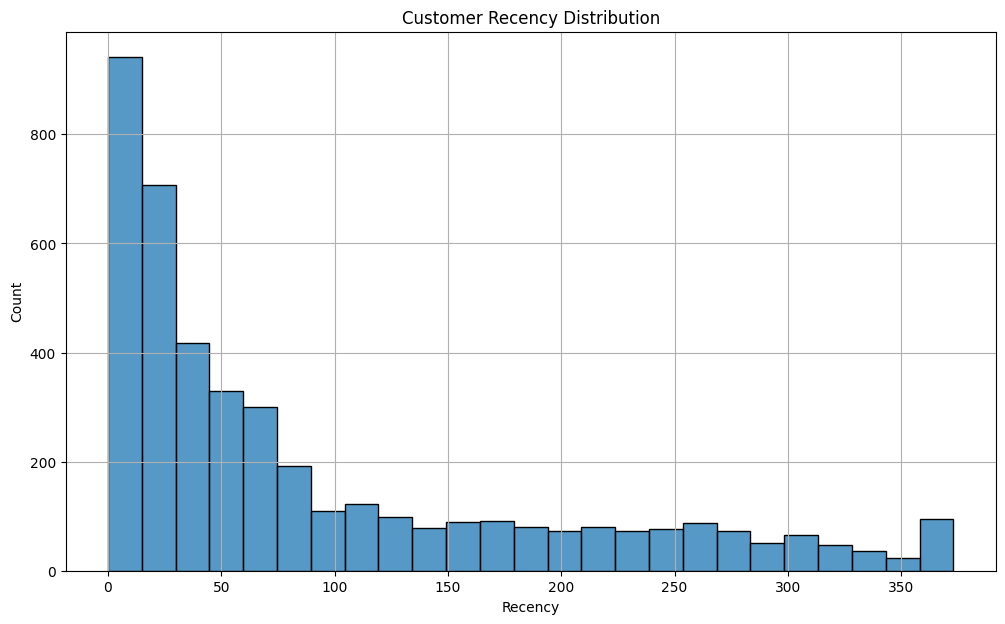

In [ ]:
# Recency histogram plot
plt.figure(figsize=(12, 7))
sns.histplot(recency)
plt.title('Customer Recency Distribution')
plt.grid()
plt.show()

### Frequency

To measure customer's frequency, we could count customer's invoice.

In [ ]:
# Count frequency
frequency = df.groupby(['CustomerID'])['InvoiceNo'].count()
frequency = frequency.rename ('Frequency')

frequency.head()

,Frequency
CustomerID,
12346.0,1
12347.0,182
12348.0,31
12349.0,73
12350.0,17


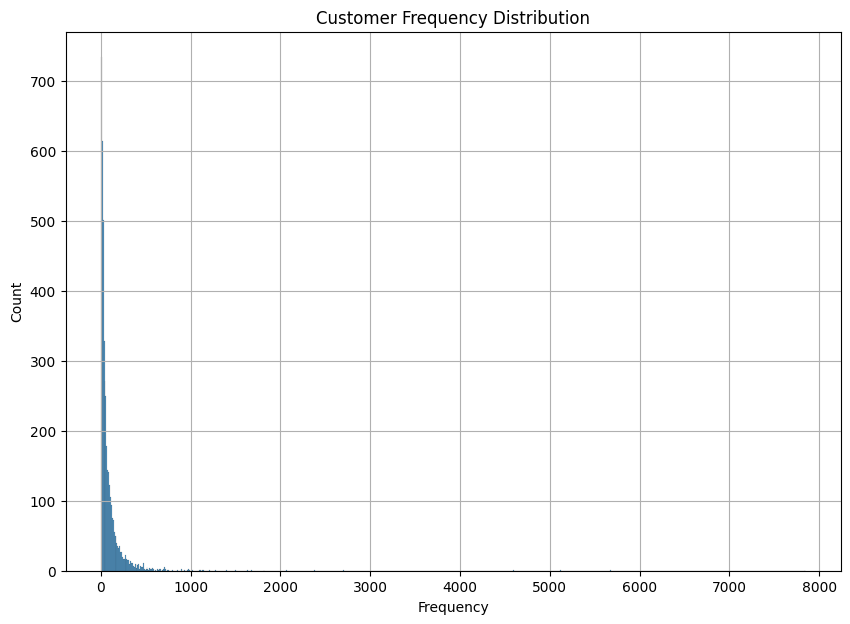

In [ ]:
# Frequency histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Frequency Distribution')
sns.histplot(frequency)
plt.grid()
plt.show();

In [ ]:
frequency.sort_values(ascending=False)

,Frequency
CustomerID,
17841.0,7847
14911.0,5675
14096.0,5111
12748.0,4595
14606.0,2700
15311.0,2379
14646.0,2076
13089.0,1818
13263.0,1677


### Monetary

To measure customer's monetary, we could sum the customer's total purchasements.

In [ ]:
# Sum the money spent
monetary = df.groupby(['CustomerID'])['TotalAmount'].sum()
monetary = monetary.rename('Monetary')

monetary.head()

,Monetary
CustomerID,
12346.0,77183.60
12347.0,4310.00
12348.0,1797.24
12349.0,1757.55
12350.0,334.40


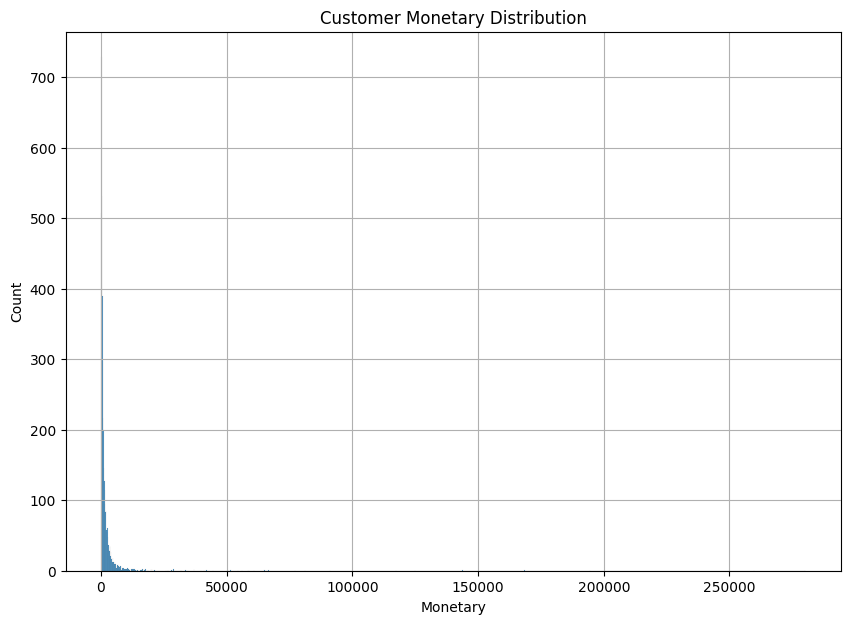

In [ ]:
# Monetary histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Monetary Distribution')
sns.histplot(monetary)
plt.grid()
plt.show()

In [ ]:
monetary.sort_values(ascending=False)

,Monetary
CustomerID,
14646.0,280206.020
18102.0,259657.300
17450.0,194550.790
16446.0,168472.500
14911.0,143825.060
12415.0,124914.530
14156.0,117379.630
17511.0,91062.380
16029.0,81024.840


### Merge the Data

The data could be separated into two dataframes. The first dataframe (log transformed data) supposed to be used when modeling and the second one (without log transformation) could be used when visualize the result.

In [ ]:
# Get customer's country of origin
country = (
    df.groupby(['CustomerID', 'Country_isUK'])
    .size()
    .reset_index()
    .drop(0, axis=1)
)#chaining method

In [ ]:
country.head()

,CustomerID,Country_isUK
0,12346.0,UK
1,12347.0,Non UK
2,12348.0,Non UK
3,12349.0,Non UK
4,12350.0,Non UK


In [ ]:
# Merge the data
df_new = country.merge(recency, on='CustomerID')\
          .merge(frequency, on='CustomerID')\
          .merge(monetary, on='CustomerID')

# Set CustomerID as index
df_new = df_new.set_index('CustomerID')
df_new.head()

,Country_isUK,Recency,Frequency,Monetary
CustomerID,,,,
12346.0,UK,325,1,77183.60
12347.0,Non UK,1,182,4310.00
12348.0,Non UK,74,31,1797.24
12349.0,Non UK,18,73,1757.55
12350.0,Non UK,309,17,334.40


### One Hot Encoding

Since our model could just accept the numeric value, we have to recode the non numeric column.

In [ ]:
# Recode the non numeric variable
df_new = pd.get_dummies(
    df_new,
    columns=['Country_isUK'],
    drop_first=True
)

df_new = df_new.rename(
    columns={'Country_isUK_UK': 'Country_UK'}
)

df_new.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,325,1,77183.60,True
12347.0,1,182,4310.00,False
12348.0,74,31,1797.24,False
12349.0,18,73,1757.55,False
12350.0,309,17,334.40,False


### Scaling

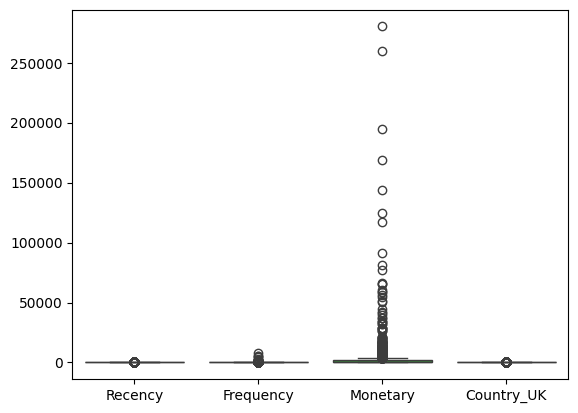

In [ ]:
sns.boxplot(data=df_new)
plt.show()

As we could see, there are variation of range in each column. We have to standardize it first.

In [ ]:
# Scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new)

df_scaled = pd.DataFrame(
    df_scaled,
    columns=df_new.columns,
    index=df_new.index
)

df_scaled.head()

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
12346.0,2.334574,-0.396578,8.358668,0.326547
12347.0,-0.905340,0.394649,0.250966,-3.062350
12348.0,-0.175360,-0.265435,-0.028596,-3.062350
12349.0,-0.735345,-0.081836,-0.033012,-3.062350
12350.0,2.174578,-0.326635,-0.191347,-3.062350


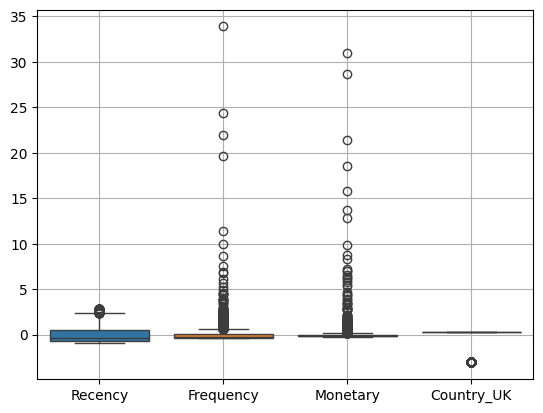

In [ ]:
# Plot scaled data
sns.boxplot(data = df_scaled)
plt.grid()
plt.show()

## Modeling

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Modeling
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = []

for k in possible_k:
  kmeans = KMeans(n_clusters = k, random_state = 42).fit(df_scaled)
  silhouette.append(silhouette_score(X = df_scaled, labels = kmeans.labels_))

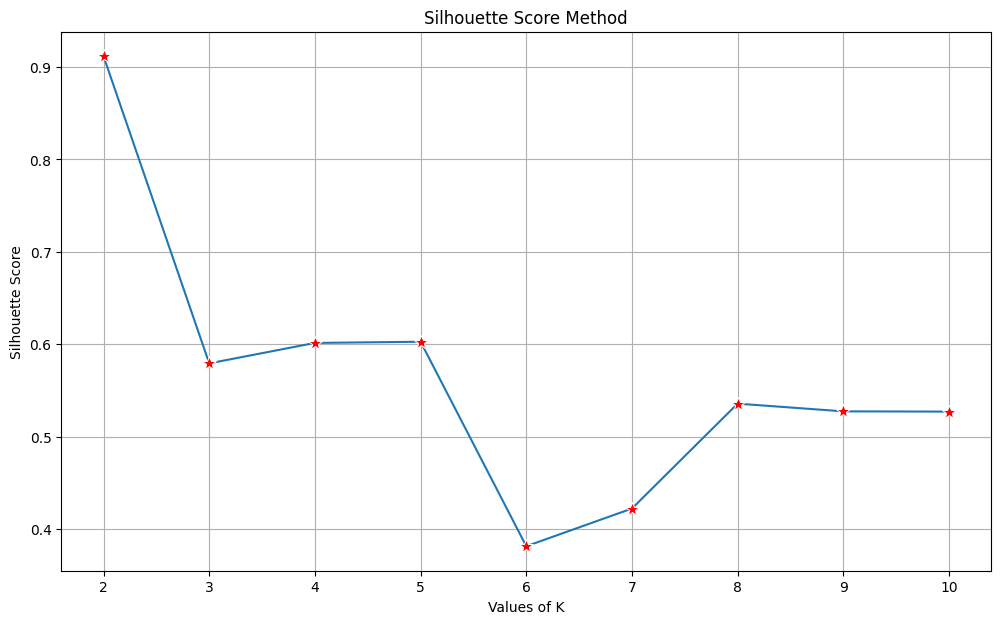

In [ ]:
# Plot the score
plt.figure(figsize=(12, 7))
sns.lineplot(
    x=possible_k,
    y=silhouette,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.grid()
plt.show();

Using silhouette score, the best K is either 2, however we try 3

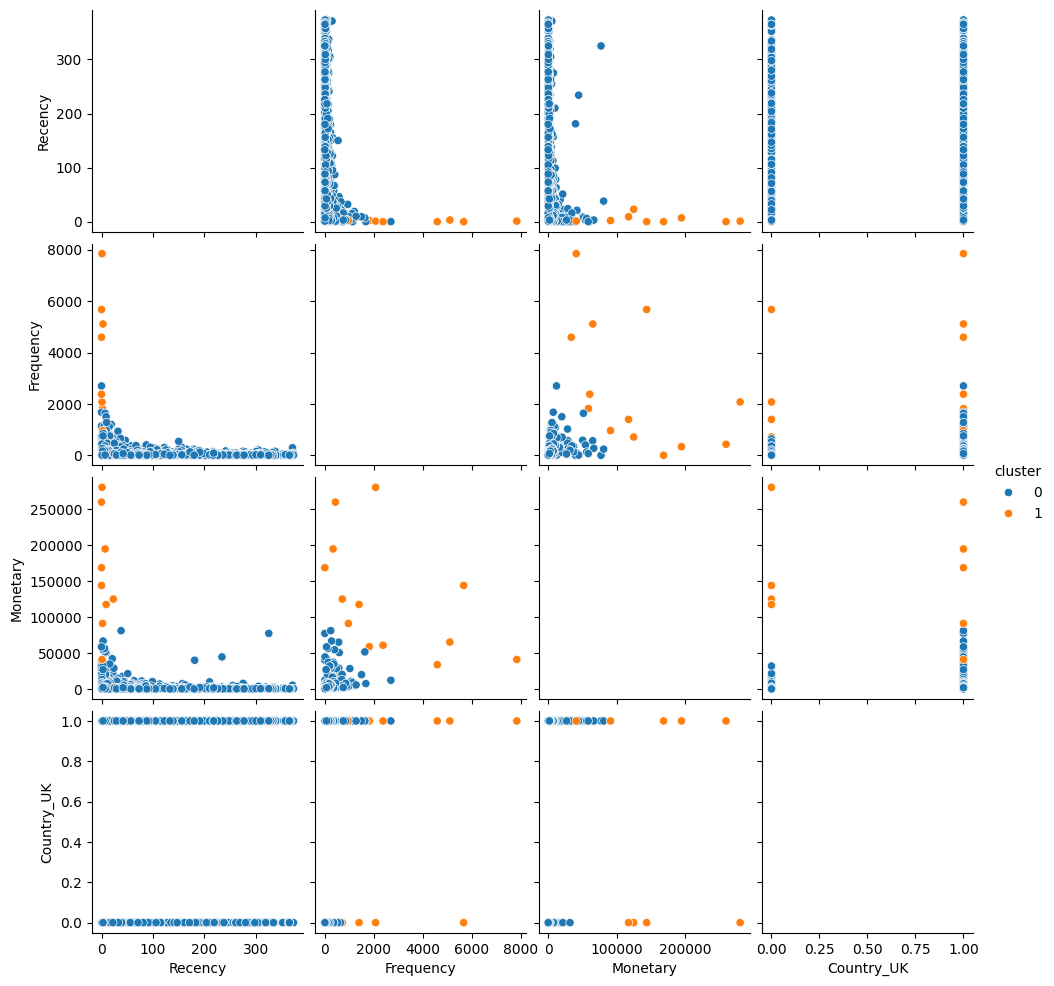

In [ ]:
#Pairplot
kmeans = KMeans(n_clusters=2,random_state=42).fit(df_scaled)

df_result_kmeans = df_new.copy()
df_result_kmeans['cluster'] = kmeans.labels_

sns.pairplot(
    data=df_result_kmeans,
    hue='cluster',
    diag_kind='None',
    palette='tab10'
)

plt.show();

In [ ]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
(
    df_result_kmeans
    .drop("Country_UK", axis = 1)
    .groupby('cluster')
    .aggregate(['count', 'mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

cluster                      0              1
Recency   count    4325.000000      13.000000
          mean       91.800462       3.692308
          std       100.047598       6.459936
          min         0.000000       0.000000
          q25        17.000000       0.000000
          median     50.000000       1.000000
          q75       142.000000       3.000000
          max       373.000000      23.000000
Frequency count    4325.000000      13.000000
          mean       84.285549    2565.307692
          std       131.516667    2456.928617
          min         1.000000       3.000000
          q25        17.000000     714.000000
          median     41.000000    1818.000000
          q75        99.000000    4595.000000
          max      2700.000000    7847.000000
Monetary  count    4325.000000      13.000000
          mean     1681.357196  126118.310000
          std      4074.628323   80607.677360
          min         3.750000   33719.730000
          q25       306.940000   60767.900000
          median    669.110000  117379.630000
          q75      1651.030000  168472.500000
          max     81024.840000  280206.020000

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Recency"].count()

cluster  Country_UK
0        False          414
         True          3911
1        False            4
         True             9
Name: Recency, dtype: int64

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Frequency"].count()

cluster  Country_UK
0        False          414
         True          3911
1        False            4
         True             9
Name: Frequency, dtype: int64

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Monetary"].count()

cluster  Country_UK
0        False          414
         True          3911
1        False            4
         True             9
Name: Monetary, dtype: int64

That's it! The customer's behavior really segmented by their country of origin.

What if we separate the customer by its country of origin before doing cluster analysis?

# Question

1. (30 point) Lakukan EDA lebih mendalam dari data yang tersedia. Misalnya: a) Siapa top 5 customer dengan pembelian terbanyak? b) Kapan waktu pembelian dengan jumlah customer terbanyak? (Misal hari apa, jam berapa, bulan apa, minggu ke berapa, dst). EDA juga bisa dilakukan menggunakan business question lain.
2. (30 point) Apa karakteristik/ciri utama dari masing-masing cluster? Apa promo yang kira-kira cocok untuk diberikan ke masing-masing cluster?
3. (40 point) Bagaimana jika segmentation difokuskan untuk customer di luar UK? Apakah terdapat insight yang menarik? Apa karakteristik utama dari cluster-cluster non UK?

#Jawaban Question 1

In [ ]:
#a. Top 5 Customer with highest Total Amount
Top_5_Customer = df.copy()
Top_5_Customer = Top_5_Customer.sort_values(by = 'TotalAmount', ascending = False)

Top_5_Customer[["CustomerID", "TotalAmount", "Quantity"]].head(5)

,CustomerID,TotalAmount,Quantity
540421,16446.0,168469.60,80995
61619,12346.0,77183.60,74215
222680,15098.0,38970.00,60
173382,16029.0,8142.75,1
348325,17450.0,7144.72,1412


In [ ]:
#a. Top 5 Customer with highest Quantity
Top_5_Customer = df.copy()
Top_5_Customer = Top_5_Customer.sort_values(by = 'Quantity', ascending = False)

Top_5_Customer[["CustomerID", "Quantity"]].head(5)

,CustomerID,Quantity
540421,16446.0,80995
61619,12346.0,74215
421632,12901.0,4800
206121,13135.0,4300
97432,18087.0,3906


In [ ]:
#a. Top 5 Customer with highest Frequency
df_new2 = df_new.sort_values(by = 'Frequency', ascending = False)
df_new2.head(5)

,Recency,Frequency,Monetary,Country_UK
CustomerID,,,,
17841.0,1,7847,40991.57,True
14911.0,0,5675,143825.06,False
14096.0,3,5111,65164.79,True
12748.0,0,4595,33719.73,True
14606.0,0,2700,12156.65,True


In [ ]:
df.groupby('CustomerID')['CustomerID'].nunique().idxmax()

12346.0

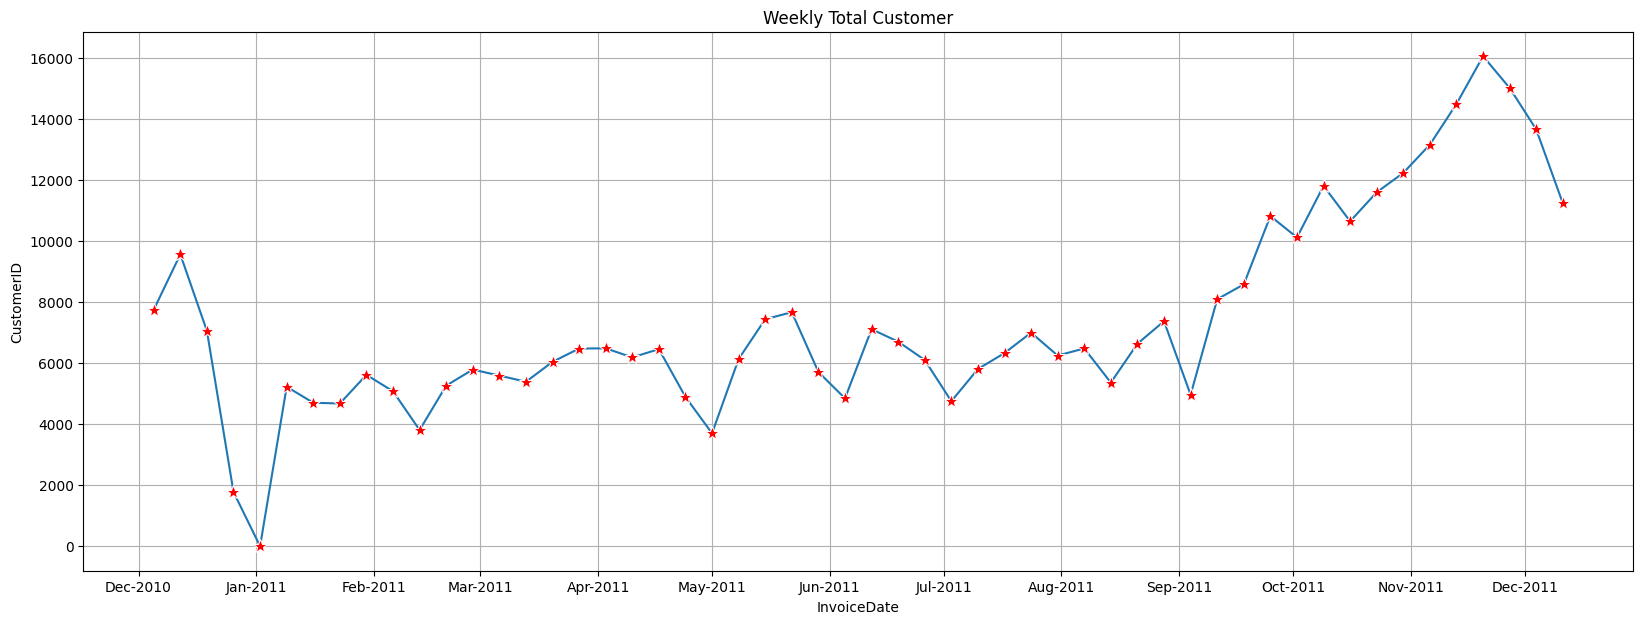

In [ ]:
#b. nunique.idxmax() --> Pada saat melakukan group by
#b. Peak Date with Highest Total Customer (Day, Month, Week, Time)

# Plot weekly trend
Total_Customer = df.copy()
Total_Customer = Total_Customer.groupby(by=pd.Grouper(key="InvoiceDate", freq="1W"))["CustomerID"].count()

plt.figure(figsize=(20, 7))
plt.title('Weekly Total Customer')
ax = sns.lineplot(
    x=Total_Customer.index,
    y=Total_Customer,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

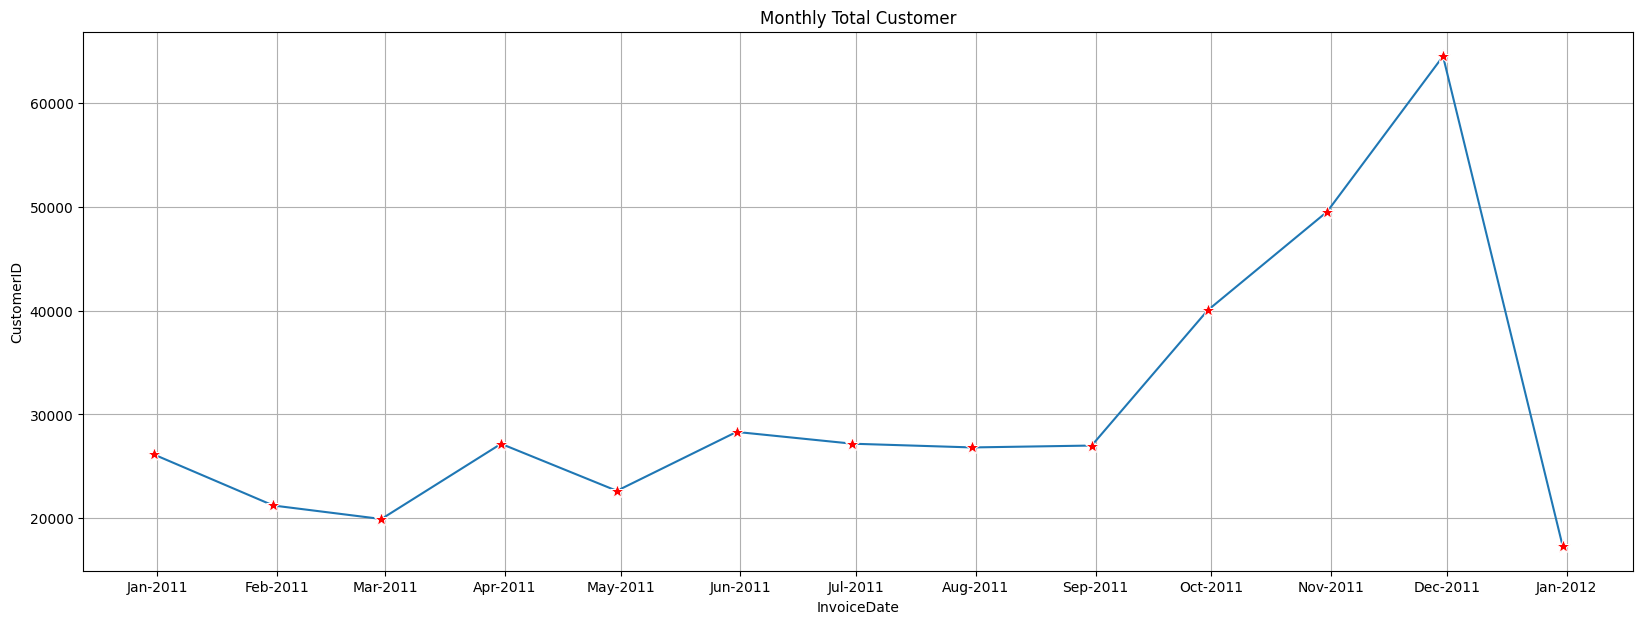

In [ ]:
# Plot monthly trend
monthly_Customer = df.copy()
monthly_Customer = monthly_Customer.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["CustomerID"].count()

plt.figure(figsize=(20, 7))
plt.title('Monthly Total Customer')
ax = sns.lineplot(
    x=monthly_Customer.index,
    y=monthly_Customer,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

Sepanjang tahun 2011, Bulan Desember 2011 menjadi bulan dengan total Customer paling tinggi, dimana Customer terbanyak terdapat di week 3 bulan Desember 2011.


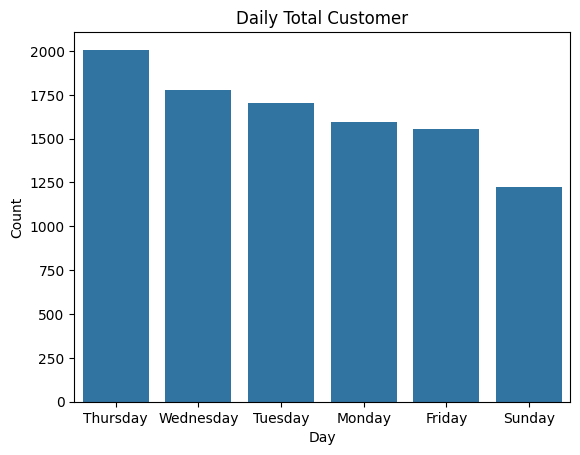

In [ ]:
daysname_purchasement = df.copy()
daysname_purchasement['Day'] = daysname_purchasement['InvoiceDate'].apply(lambda x: x.strftime("%A"))

days_count = daysname_purchasement.groupby(by='Day')['CustomerID']\
                                  .nunique()\
                                  .rename('Count')\
                                  .sort_values(ascending=False)

plt.title('Daily Total Customer')
sns.barplot(days_count)
plt.show()

Hari kamis adalah hari dengan total customer paling banyak.

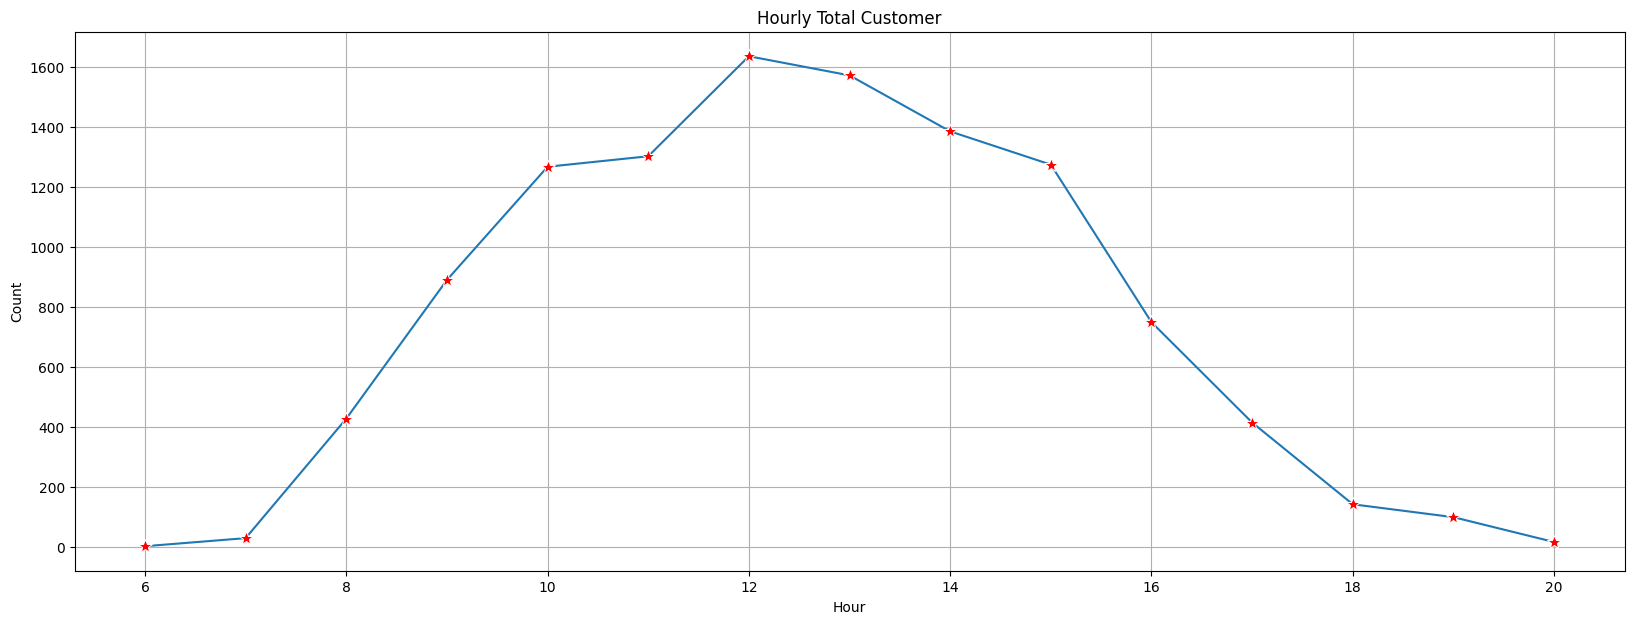

In [ ]:
hourly_purchasement = daysname_purchasement.copy()
hourly_count = hourly_purchasement.groupby(by=[hourly_purchasement['InvoiceDate'].dt.hour])['CustomerID'].nunique().rename('Count')
hourly_count.index.names = ['Hour']

plt.figure(figsize=(20, 7))
plt.title('Hourly Total Customer')
ax = sns.lineplot(
    x=hourly_count.index,
    y=hourly_count,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
plt.grid()
plt.show()

Pukul 12 hingga 2 siang adalah waktu dengan total customer terbanyak.

#Jawaban Question 2


In [ ]:
#Karakteristik Tiap Cluster --> explore berbagai kemungkinan total k
#dengan menggunakan random state 42 dan k = 2

* Karakteristik Utama Cluster 0:

  Customer di cluster ini cenderung kurang aktif (Recency tinggi) dan belanja dalam frekuensi serta pengeluaran yang lebih rendah.

* Karakteristik Utama Cluster 1:

  Customer di cluster ini sangat aktif dengan frekuensi pembelian dan pengeluaran yang tinggi. Mereka adalah pembeli yang loyal dan sering berbelanja.

* Promo yang Cocok untuk Cluster 0:
  1.   Reactivation Promo: Mengingat Recency yang tinggi, promo yang bisa digunakan  adalah diskon khusus atau hadiah untuk mendorong mereka kembali berbelanja, seperti “Belanja Lagi untuk Mendapatkan Diskon 20%”.
  2.   Volume Discounts: Karena Frequency dan Monetary rendah, promo berbasis jumlah pembelian atau peningkatan pengeluaran bisa menarik, seperti "Beli 2, Gratis 1" atau diskon khusus untuk pembelian besar.

* Promo yang Cocok untuk Cluster 1:
  1.   Loyalty Rewards: Customer di cluster ini dapat diberikan program loyalitas seperti "Exclusive Membership" atau program poin belanja untuk meningkatkan retensi mereka.
  2.   Early Access atau Special Discount: Karena mereka merupakan pembeli setia, memberikan akses awal ke produk baru atau diskon eksklusif bisa menjadi cara yang bagus untuk menjaga loyalitas mereka.

#Jawaban Question 3

In [ ]:
#segmentation non-UK
df_nonUK = df[(df["Country_isUK"] == 'Non UK')]
df_nonUK.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0,France,Non UK,90.0
27,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0,France,Non UK,90.0
28,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France,Non UK,45.0
29,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583.0,France,Non UK,10.2
30,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0,France,Non UK,15.6




> RFM

In [ ]:
# Get customer's recency
recency2=df_nonUK.groupby(['CustomerID'])['InvoiceDate'].max() #Recent Transaction of customer
recency2 = max(recency2)-recency2 #Latest Transaction Date - Customer latest transaction date
recency2 = recency2.dt.days
recency2 = recency2.rename('Recency2')

recency2.head()

,Recency2
CustomerID,
12347.0,1
12348.0,74
12349.0,18
12350.0,309
12352.0,35


In [ ]:
# Count frequency
frequency2 = df_nonUK.groupby(['CustomerID'])['InvoiceNo'].count()
frequency2 = frequency2.rename ('Frequency2')

frequency2.head()

,Frequency2
CustomerID,
12347.0,182
12348.0,31
12349.0,73
12350.0,17
12352.0,85


In [ ]:
# Sum the money spent
monetary2 = df_nonUK.groupby(['CustomerID'])['TotalAmount'].sum()
monetary2 = monetary2.rename('Monetary2')

monetary2.head()

,Monetary2
CustomerID,
12347.0,4310.00
12348.0,1797.24
12349.0,1757.55
12350.0,334.40
12352.0,2506.04


In [ ]:
# Merge the data
df_new2 = country.merge(recency2, on='CustomerID')\
          .merge(frequency2, on='CustomerID')\
          .merge(monetary2, on='CustomerID')

# Set CustomerID as index
df_new2 = df_new2.set_index('CustomerID')
df_new2.head()

,Country_isUK,Recency2,Frequency2,Monetary2
CustomerID,,,,
12347.0,Non UK,1,182,4310.00
12348.0,Non UK,74,31,1797.24
12349.0,Non UK,18,73,1757.55
12350.0,Non UK,309,17,334.40
12352.0,Non UK,35,85,2506.04



> One Hot Encoding



In [ ]:
# Recode the non numeric variable
df_new2 = pd.get_dummies(
    df_new2,
    columns=['Country_isUK'],
    drop_first=True
)

df_new2 = df_new2.rename(
    columns={'Country_isUK_UK': 'Country_nUK'}
)

df_new2.head()

,Recency2,Frequency2,Monetary2
CustomerID,,,
12347.0,1,182,4310.00
12348.0,74,31,1797.24
12349.0,18,73,1757.55
12350.0,309,17,334.40
12352.0,35,85,2506.04




> Scaling



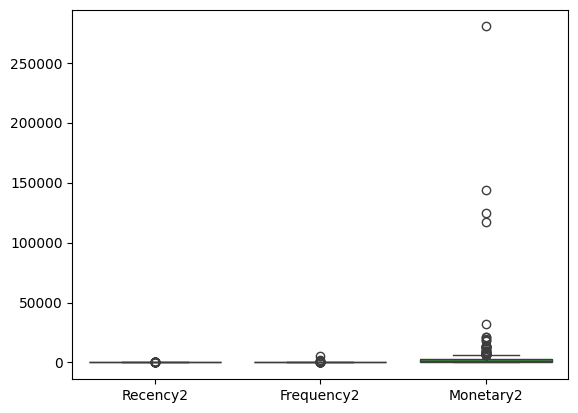

In [ ]:
sns.boxplot(data=df_new2)
plt.show()

In [ ]:
# Scale the data
scaler2 = StandardScaler()
df_scaled2 = scaler2.fit_transform(df_new2)

df_scaled2 = pd.DataFrame(
    df_scaled2,
    columns=df_new2.columns,
    index=df_new2.index
)

df_scaled2.head()

,Recency2,Frequency2,Monetary2
CustomerID,,,
12347.0,-0.896621,0.248302,0.026983
12348.0,-0.197122,-0.233730,-0.115746
12349.0,-0.733724,-0.099655,-0.118001
12350.0,2.054690,-0.278422,-0.198838
12352.0,-0.570827,-0.061348,-0.075485


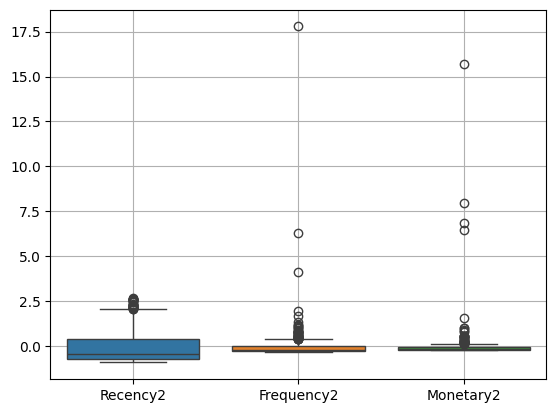

In [ ]:
# Plot scaled data
sns.boxplot(data = df_scaled2)
plt.grid()
plt.show()



> Modeling



In [ ]:
# Modeling
possible_k2 = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette2 = []

for k in possible_k2:
  kmeans2 = KMeans(n_clusters = k, random_state = 42).fit(df_scaled2)
  silhouette2.append(silhouette_score(X = df_scaled2, labels = kmeans2.labels_))

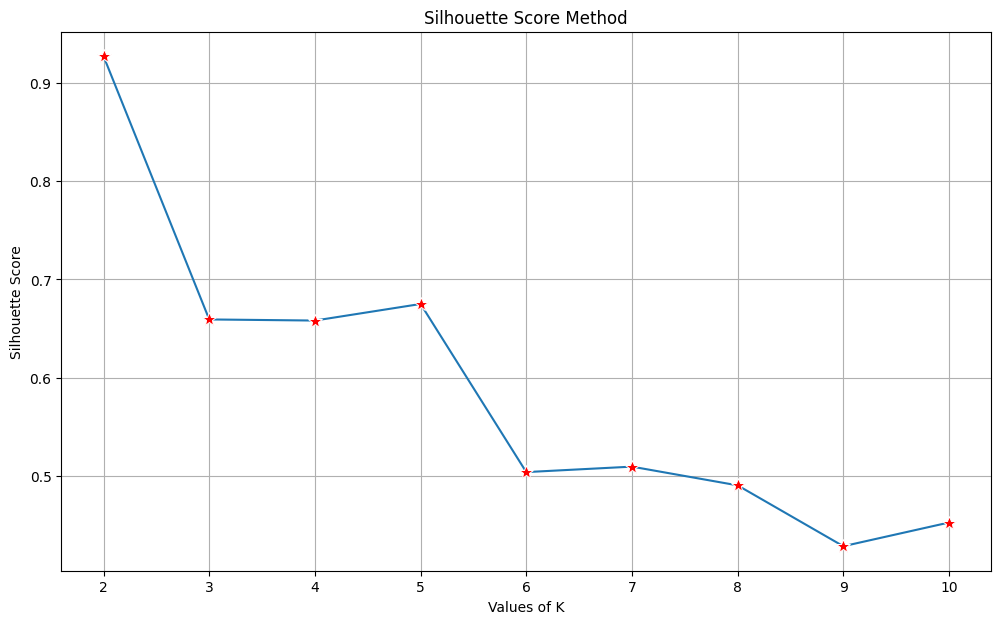

In [ ]:
# Plot the score
plt.figure(figsize=(12, 7))
sns.lineplot(
    x=possible_k2,
    y=silhouette2,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.grid()
plt.show();

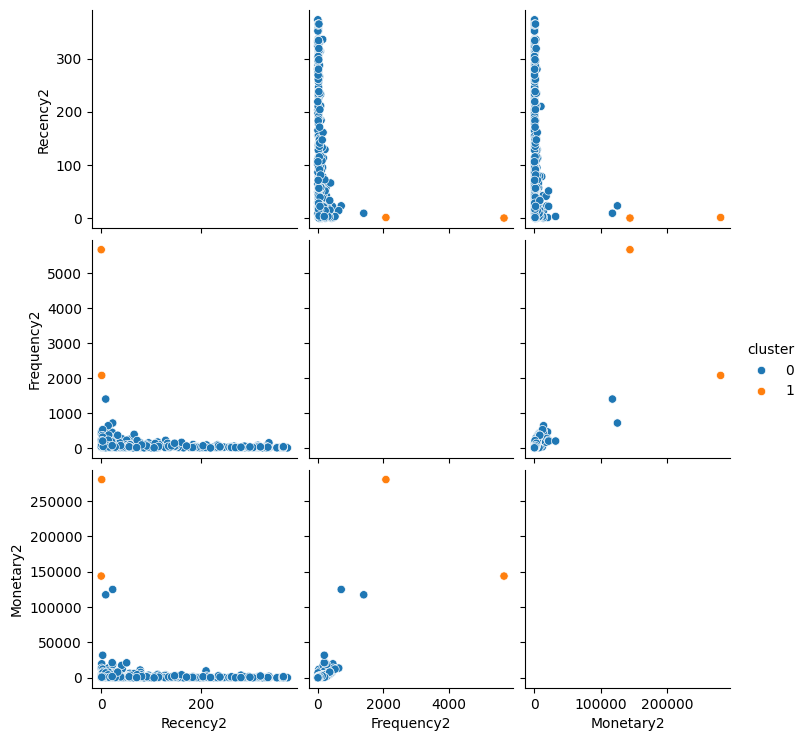

In [ ]:
#Pairplot
kmeans2 = KMeans(n_clusters=2,random_state=42).fit(df_scaled2)

df_result_kmeans2 = df_new2.copy()
df_result_kmeans2['cluster'] = kmeans2.labels_

sns.pairplot(
    data=df_result_kmeans2,
    hue='cluster',
    diag_kind='None',
    palette='tab10'
)

plt.show();

In [ ]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
(
    df_result_kmeans2
    .groupby('cluster')
    .aggregate(['count', 'mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

cluster                        0              1
Recency2   count      416.000000       2.000000
           mean        95.024038       0.500000
           std        104.532139       0.707107
           min          0.000000       0.000000
           q25         18.000000       0.250000
           median      51.500000       0.500000
           q75        135.500000       0.750000
           max        373.000000       1.000000
Frequency2 count      416.000000       2.000000
           mean        86.086538    3875.500000
           std        119.840344    2544.877305
           min          1.000000    2076.000000
           q25         21.750000    2975.750000
           median      45.000000    3875.500000
           q75        101.000000    4775.250000
           max       1400.000000    5675.000000
Monetary2  count      416.000000       2.000000
           mean      2834.099207  212015.540000
           std       8938.916929   96435.901641
           min         51.560000  143825.060000
           q25        460.150000  177920.300000
           median    1031.195000  212015.540000
           q75       2667.500000  246110.780000
           max     124914.530000  280206.020000

In [ ]:
df_result_kmeans2.groupby(["cluster"])["Recency2"].count()

,Recency2
cluster,
0,416
1,2


In [ ]:
df_result_kmeans2.groupby(["cluster"])["Frequency2"].count()

,Frequency2
cluster,
0,416
1,2


In [ ]:
df_result_kmeans2.groupby(["cluster"])["Monetary2"].count()

,Monetary2
cluster,
0,416
1,2


* Insight yang Menarik:
  * Cluster 0 memiliki mayoritas customer dengan aktivitas pembelian yang lebih rendah baik dalam hal frekuensi maupun pengeluaran. Customer ini mungkin merupakan pembeli internasional yang berbelanja sesekali dan memprioritaskan pembelian dalam jumlah besar untuk menghemat biaya pengiriman.

  * Cluster 1 terdiri dari customer luar UK yang sangat aktif dan berpengeluaran besar. Mereka mungkin merupakan VIP customer yang berbelanja dalam jumlah besar dan sering melakukan pembelian. Promo untuk mereka harus sangat personal dan eksklusif.

* Karakteristik Utama Cluster Non-UK:
  * Cluster 0: Customer cenderung tidak aktif (recency tinggi), dengan pengeluaran dan frekuensi transaksi yang bervariasi dari rendah hingga menengah. Sebagian besar mereka mungkin hanya berbelanja saat ada kebutuhan besar atau promosi yang menarik.
  * Cluster 1: Ini adalah customer super loyal yang sering berbelanja dan memiliki pengeluaran besar. Mereka mungkin membeli dalam jumlah besar atau berlangganan produk tertentu secara rutin.

* Promo yang Cocok untuk Customer di Luar UK:
  * Cluster 0:
  1. Promo Free Shipping Internasional: Untuk menarik mereka kembali, bisa ditawarkan pengiriman gratis atau potongan biaya pengiriman pada pembelian berikutnya.
  2. Bundle Deals atau Diskon Volume: Mengingat bahwa beberapa customer mungkin cenderung berbelanja dalam jumlah besar namun jarang, promo yang menawarkan diskon jika membeli dalam jumlah banyak bisa efektif.

  * Cluster 1:
  1. Exclusive VIP Discounts: Mengingat mereka adalah high-value customer, promo eksklusif seperti "VIP Early Access" atau diskon khusus untuk mereka dapat meningkatkan loyalitas.
  2. Personalized Offers: Promo yang dipersonalisasi berdasarkan preferensi pembelian mereka, seperti penawaran produk yang sesuai dengan histori pembelian.